# Setup

In [1]:
import gc
gc.enable()

import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')
warnings.filterwarnings(category=UserWarning, action='ignore')

import time
import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold
)
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)

SEED = 2024

# Data preparation

In [2]:
data = pd.read_csv('/kaggle/input/predict-online-course-engagement-dataset/online_course_engagement_data.csv')

In [3]:
TARGET = 'CourseCompletion'
features = [f for f in data.columns if f not in ('UserID', TARGET)]
cat_features = ['DeviceType', 'CourseCategory']
num_features = [f for f in features if f not in cat_features]

### Preprocessing

In [4]:
def preprocess_dataset(df):
    # remove duplicates
    df = df.drop_duplicates(ignore_index=True)
    
    # one-hot encoding nominal variable
    df = pd.get_dummies(df, columns=['CourseCategory'], dtype='int8')
    
    df['DeviceType'] = df['DeviceType'].astype('int8')
    
    # binarize numerical features
    df['time_spent_above_threshold'] = (df['TimeSpentOnCourse'] > 20).astype('int8')
    df['num_videos_above_threshold'] = (df['NumberOfVideosWatched'] > 5).astype('int8')
    df['num_quizzes_above_threshold'] = (df['NumberOfQuizzesTaken'] > 3).astype('int8')
    df['quiz_scores_above_threshold'] = (df['QuizScores'] > 68).astype('int8')
    df['completion_above_threshold'] = (df['CompletionRate'] > 60).astype('int8')
    
    return df

In [5]:
data = preprocess_dataset(data.copy())

### Feature sets

Generated in: [Online Course Engagement - Logistic Regression](https://www.kaggle.com/code/sid4ds/online-course-engagement-logistic-regression)

In [6]:
original_features = [
    'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 
    'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 
    'CourseCategory_Business', 'CourseCategory_Health', 
    'CourseCategory_Programming', 'CourseCategory_Science'
]

extended_features = [
    'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 
    'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 
    'CourseCategory_Business', 'CourseCategory_Health', 
    'CourseCategory_Programming', 'CourseCategory_Science', 
    'time_spent_above_threshold', 'num_videos_above_threshold', 
    'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 
    'completion_above_threshold'
]

binary_features = [
    'DeviceType', 'CourseCategory_Arts', 'CourseCategory_Business', 
    'CourseCategory_Health', 'CourseCategory_Programming', 
    'CourseCategory_Science', 'time_spent_above_threshold', 
    'num_videos_above_threshold', 'num_quizzes_above_threshold', 
    'quiz_scores_above_threshold', 'completion_above_threshold'
]

minimal_features = [
    'time_spent_above_threshold', 'num_videos_above_threshold', 
    'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 
    'completion_above_threshold'
]

In [7]:
feature_sets = {
    'Original': original_features,
    'Extended': extended_features,
    'Binary': binary_features,
    'Minimal': minimal_features
}

### Holdout set for model-testing
(exactly the same as used in previous modeling experiments)

In [8]:
train, test, _, _ = train_test_split(
    data, data[TARGET],
    stratify=data[TARGET],
    test_size=0.1,  # same size
    shuffle=True,
    random_state=SEED  # same sampling
)

# Modeling framework

In [9]:
def cross_validate(estimator, feature_set, num_folds=9):
    global train, TARGET
    
    scores_auc, scores_acc = [], []
    X, y = train[feature_set], train[TARGET]
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    for fold, (train_ids, val_ids) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        
        model = clone(estimator)
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_val)[:, 1]
        scores_auc.append(roc_auc_score(y_val, probs))
        preds = model.predict(X_val)
        scores_acc.append(accuracy_score(y_val, preds))
        
    scores_df = pd.DataFrame(
        data={'Accuracy': scores_acc, 'ROC-AUC': scores_auc}, 
        index=[f'Fold #{i+1}' for i in range(9)]
    )
    display(scores_df.T)

In [10]:
def refit_full_and_evaluate(model, feature_set):
    global train, TARGET
    
    model.fit(train[feature_set], train[TARGET])
    probs = model.predict_proba(test[feature_set])[:, 1]
    preds = model.predict(test[feature_set])
    
    accuracy = accuracy_score(test[TARGET], preds)
    auc = roc_auc_score(test[TARGET], probs)
    print(f'|| Accuracy: {accuracy:.4f} || ROC-AUC: {auc:.4f} ||\n')
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('Normalized Confusion Matrix')
    sns.heatmap(
        data=confusion_matrix(test[TARGET], preds, normalize='true'),
        annot=True, fmt='.4f', linewidths=0.1, cmap=plt.cm.Blues
    )
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.show()
    
    return model

In [11]:
def save_model(model, config, notebook='02'):
    save_path = f'{notebook}_{config}.joblib'
    joblib.dump(model, save_path)

In [12]:
def run_experiment(estimator, model_name, save=True):
    global feature_sets
    
    for fname, fset in feature_sets.items():
        print('\n', '-'*25, fname, '-'*25)
        start_time = time.time()
        print('Cross-validation:')
        cross_validate(estimator, fset)
        print('Refit to full training data and evaluate:\n')
        model = refit_full_and_evaluate(estimator, fset)
        end_time = time.time()
        print(f'\n(Time taken: {end_time - start_time:.2f} secs)')
        
        if save:
            save_model(model, f'{model_name}_{fname}')

# Discriminant Analysis

## Linear

In [13]:
model = make_pipeline(
    StandardScaler(), 
    LinearDiscriminantAnalysis(solver='svd', tol=1e-4)
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.7823,0.7934,0.7956,0.7857,0.7808,0.7833,0.8030,0.7968,0.8091
ROC-AUC,0.8569,0.8583,0.8686,0.8707,0.8581,0.8576,0.8858,0.8720,0.8921


Refit to full training data and evaluate:

|| Accuracy: 0.7798 || ROC-AUC: 0.8665 ||



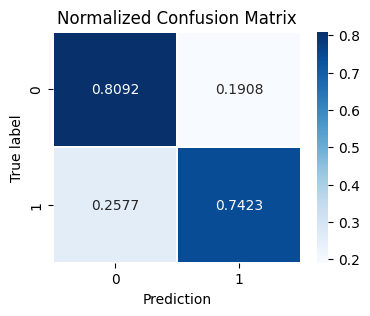


(Time taken: 0.59 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9557,0.9398,0.9466,0.9482,0.9546,0.9419,0.9527,0.9626,0.9644


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9597 ||



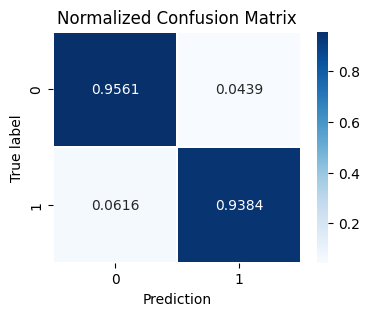


(Time taken: 0.96 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9461,0.9325,0.9377,0.9444,0.9531,0.9367,0.9447,0.9567,0.9545


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9514 ||



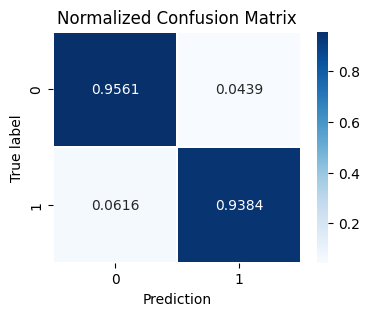


(Time taken: 0.51 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9464,0.9295,0.9385,0.9448,0.9536,0.9377,0.9498,0.9562,0.9538


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9517 ||



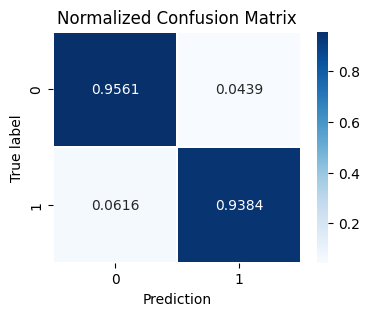


(Time taken: 0.33 secs)


In [14]:
run_experiment(model, 'lda')

## Quadratic

In [15]:
model = make_pipeline(
    StandardScaler(),
    QuadraticDiscriminantAnalysis(reg_param=0.5, tol=1e-4)
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8057,0.7970,0.8128,0.8153,0.8079,0.7968,0.8202,0.8128,0.8362
ROC-AUC,0.8746,0.8722,0.8837,0.8884,0.8734,0.8761,0.8993,0.8881,0.9080


Refit to full training data and evaluate:

|| Accuracy: 0.8057 || ROC-AUC: 0.8835 ||



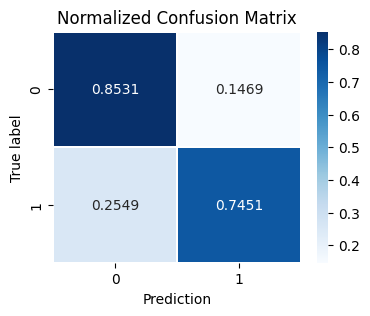


(Time taken: 0.50 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9237,0.9384,0.9310,0.9236,0.9286,0.9335,0.9495,0.9507
ROC-AUC,0.9484,0.9311,0.9453,0.9449,0.9452,0.9452,0.9450,0.9598,0.9700


Refit to full training data and evaluate:

|| Accuracy: 0.9434 || ROC-AUC: 0.9595 ||



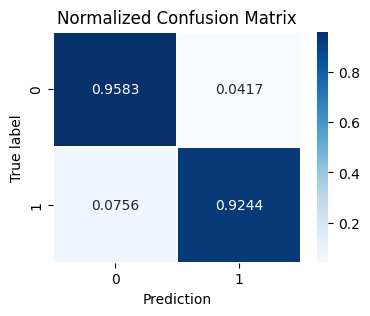


(Time taken: 0.55 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9433,0.9409,0.936,0.9347,0.9372,0.9544,0.9557
ROC-AUC,0.9449,0.9341,0.9437,0.9364,0.947,0.9427,0.9373,0.9564,0.9664


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9573 ||



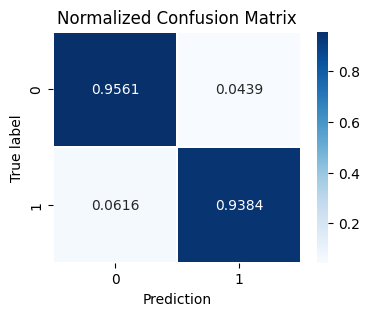


(Time taken: 0.66 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.941,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.945,0.9304,0.9430,0.9337,0.9442,0.9434,0.9385,0.9561,0.9657


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9560 ||



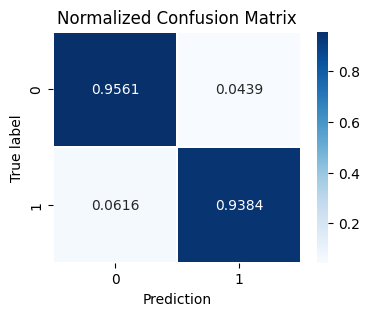


(Time taken: 0.40 secs)


In [16]:
run_experiment(model, 'qda')

# Naive Bayes - BernoulliNB
(Works only for binary features)

In [17]:
bnb_model = BernoulliNB(alpha=0.5)

------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9491,0.9340,0.9417,0.9437,0.9503,0.9366,0.9422,0.9564,0.9604


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9582 ||



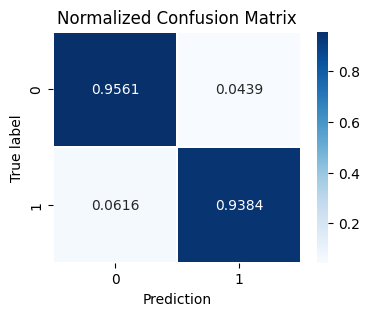


(Time taken: 0.38 secs)


In [18]:
print('-'*25, 'Binary', '-'*25)
start_time = time.time()
print('Cross-validation:')
cross_validate(bnb_model, binary_features)
print('Refit to full training data and evaluate:\n')
bnb_model = refit_full_and_evaluate(bnb_model, binary_features)
end_time = time.time()
print(f'\n(Time taken: {end_time - start_time:.2f} secs)')

save_model(bnb_model, 'bernoullinb_Binary')

------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9467,0.9321,0.9406,0.9436,0.9459,0.9365,0.9468,0.9568,0.9588


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9546 ||



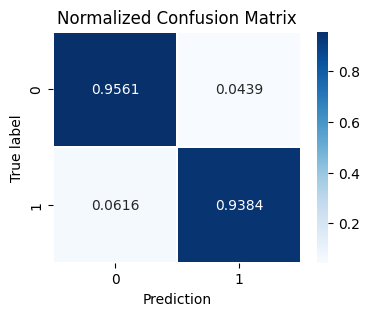


(Time taken: 0.35 secs)


In [19]:
print('-'*25, 'Minimal', '-'*25)
start_time = time.time()
print('Cross-validation:')
cross_validate(bnb_model, minimal_features)
print('Refit to full training data and evaluate:\n')
model = refit_full_and_evaluate(bnb_model, minimal_features)
end_time = time.time()
print(f'\n(Time taken: {end_time - start_time:.2f} secs)')

save_model(bnb_model, 'bernoullinb_Minimal')

# K-Nearest Neighbors

In [20]:
model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(
        n_neighbors=5, 
        weights='distance', 
        n_jobs=-1
    )
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8426,0.8303,0.8596,0.8559,0.8411,0.8424,0.8448,0.8633,0.8547
ROC-AUC,0.9062,0.8915,0.9013,0.9108,0.9090,0.8917,0.9152,0.9188,0.9280


Refit to full training data and evaluate:

|| Accuracy: 0.8438 || ROC-AUC: 0.9086 ||



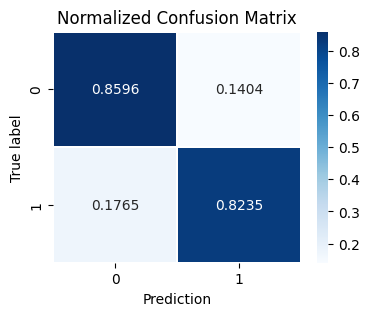


(Time taken: 1.04 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9385,0.9262,0.9421,0.9372,0.9409,0.9335,0.9347,0.9483,0.9557
ROC-AUC,0.9443,0.9309,0.9481,0.9408,0.9464,0.9318,0.9527,0.9563,0.9584


Refit to full training data and evaluate:

|| Accuracy: 0.9471 || ROC-AUC: 0.9468 ||



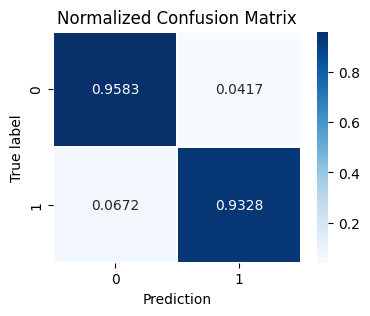


(Time taken: 0.72 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9397,0.9299,0.9409,0.9409,0.9409,0.9384,0.9372,0.9569,0.9544
ROC-AUC,0.9402,0.9341,0.9449,0.9414,0.9506,0.9312,0.9455,0.9613,0.9589


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9464 ||



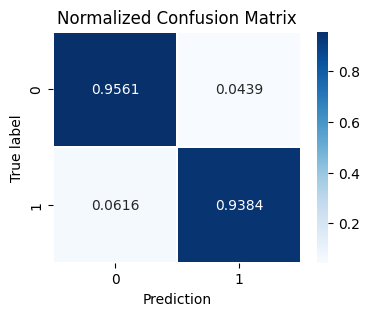


(Time taken: 1.08 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9360,0.9569,0.9557
ROC-AUC,0.9496,0.9269,0.9439,0.9429,0.9462,0.9377,0.9468,0.9533,0.9537


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9522 ||



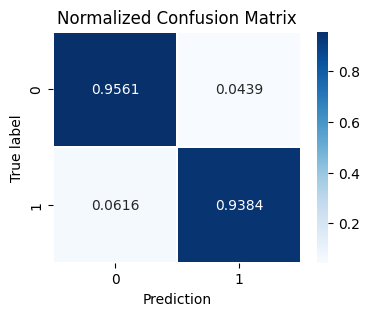


(Time taken: 1.03 secs)


In [21]:
run_experiment(model, 'knn')

# Decision Tree

In [22]:
model = DecisionTreeClassifier(
    max_depth=4, 
    class_weight='balanced',
    random_state=SEED
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8770,0.8831,0.9002,0.8929,0.8879,0.8892,0.9187,0.9015,0.9039
ROC-AUC,0.9299,0.9145,0.9270,0.9267,0.9333,0.9218,0.9526,0.9378,0.9424


Refit to full training data and evaluate:

|| Accuracy: 0.8905 || ROC-AUC: 0.9309 ||



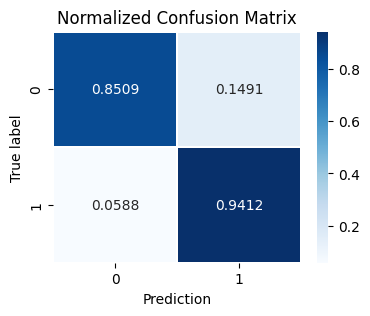


(Time taken: 0.49 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8770,0.8831,0.9002,0.8929,0.8879,0.8892,0.9187,0.9015,0.9039
ROC-AUC,0.9299,0.9145,0.9270,0.9267,0.9333,0.9218,0.9526,0.9378,0.9424


Refit to full training data and evaluate:

|| Accuracy: 0.8905 || ROC-AUC: 0.9309 ||



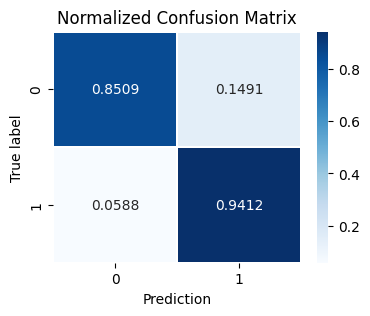


(Time taken: 0.53 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8610,0.8708,0.8867,0.8768,0.8768,0.8768,0.8978,0.8904,0.8855
ROC-AUC,0.9162,0.9062,0.9245,0.9152,0.9224,0.9153,0.9364,0.9344,0.9287


Refit to full training data and evaluate:

|| Accuracy: 0.8782 || ROC-AUC: 0.9203 ||



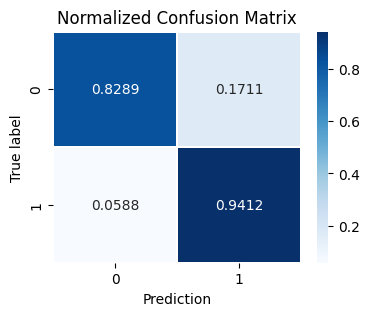


(Time taken: 0.39 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8610,0.8708,0.8867,0.8768,0.8768,0.8768,0.8978,0.8904,0.8855
ROC-AUC,0.9168,0.9020,0.9229,0.9097,0.9177,0.9135,0.9364,0.9335,0.9291


Refit to full training data and evaluate:

|| Accuracy: 0.8782 || ROC-AUC: 0.9209 ||



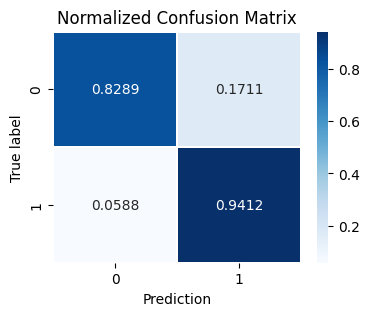


(Time taken: 0.37 secs)


In [23]:
run_experiment(model, 'dtree')

# Random Forest

In [24]:
model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED,
    n_jobs=1
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9422,0.9544,0.9569,0.9544,0.9483,0.9594,0.9643,0.9692
ROC-AUC,0.9582,0.9361,0.9462,0.9447,0.9548,0.9477,0.9575,0.9642,0.9671


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9617 ||



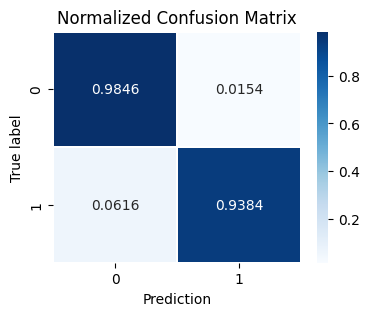


(Time taken: 6.94 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9446,0.9581,0.9557,0.9557,0.9495,0.9594,0.9655,0.9717
ROC-AUC,0.9579,0.9411,0.9438,0.9499,0.9577,0.9475,0.9616,0.9623,0.9678


Refit to full training data and evaluate:

|| Accuracy: 0.9619 || ROC-AUC: 0.9608 ||



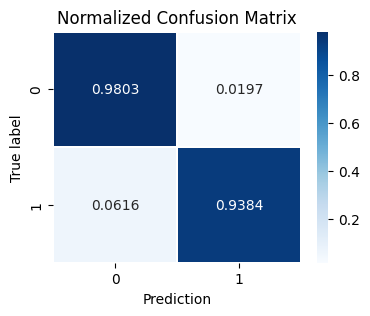


(Time taken: 6.86 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.941,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.946,0.9324,0.9386,0.9345,0.9515,0.9421,0.9385,0.9606,0.9614


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9512 ||



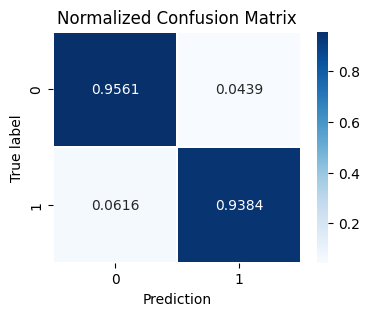


(Time taken: 3.95 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9514,0.9303,0.9474,0.9467,0.9462,0.9421,0.9542,0.9583,0.9628


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9529 ||



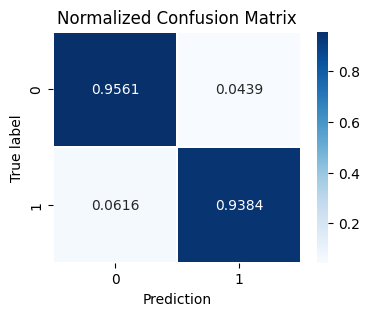


(Time taken: 3.48 secs)


In [25]:
run_experiment(model, 'rforest')

# AdaBoost

In [26]:
base_estimator = DecisionTreeClassifier(
    max_depth=5, 
    class_weight='balanced',
    random_state=SEED
)

model = AdaBoostClassifier(
    estimator=base_estimator, 
    n_estimators=50, 
    learning_rate=0.05,
    algorithm='SAMME',
    random_state=SEED
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9594,0.9446,0.9569,0.9569,0.9557,0.9483,0.9581,0.9655,0.9717
ROC-AUC,0.9550,0.9410,0.9561,0.9523,0.9562,0.9439,0.9616,0.9626,0.9681


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9644 ||



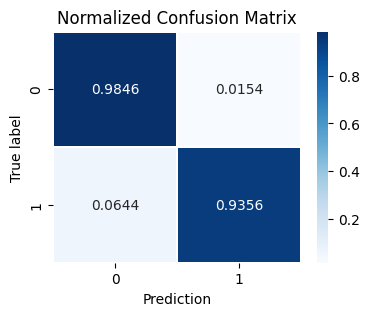


(Time taken: 11.96 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9594,0.9446,0.9569,0.9569,0.9557,0.9483,0.9581,0.9655,0.9717
ROC-AUC,0.9550,0.9410,0.9561,0.9523,0.9562,0.9447,0.9616,0.9626,0.9681


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9645 ||



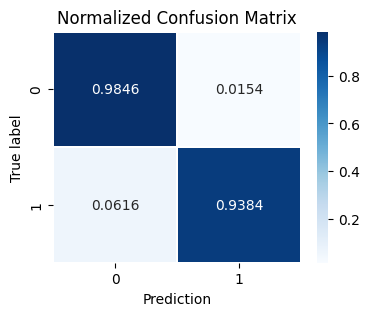


(Time taken: 12.67 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9464,0.9300,0.9443,0.9400,0.9433,0.9347,0.9467,0.9597,0.9614


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9500 ||



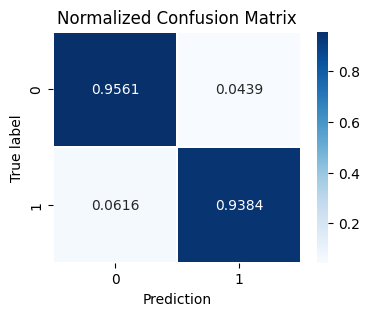


(Time taken: 4.43 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9425,0.9255,0.9438,0.9406,0.9401,0.9373,0.9433,0.9599,0.9592


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9456 ||



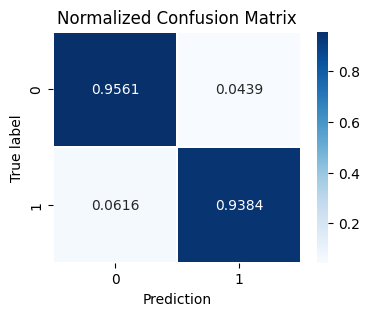


(Time taken: 3.41 secs)


In [27]:
run_experiment(model, 'adaboost')

# Hist-Gradient Boosting

In [28]:
categorical_features = [f for f in extended_features if f not in num_features]
train[categorical_features] = train[categorical_features].astype('category')
test[categorical_features] = test[categorical_features].astype('category')

In [29]:
HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=1000,
    max_depth=5,
    tol=1e-4,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1,
    categorical_features="from_dtype",
    scoring=make_scorer(roc_auc_score),
    class_weight='balanced',
    random_state=SEED
)

HistGradientBoostingClassifier(categorical_features='from_dtype',
                               class_weight='balanced', early_stopping=True,
                               max_depth=5, max_iter=1000, n_iter_no_change=20,
                               random_state=2024,
                               scoring=make_scorer(roc_auc_score), tol=0.0001)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9594,0.9446,0.9569,0.9569,0.9557,0.9483,0.9581,0.9655,0.9717
ROC-AUC,0.9550,0.9410,0.9561,0.9523,0.9562,0.9439,0.9616,0.9626,0.9681


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9644 ||



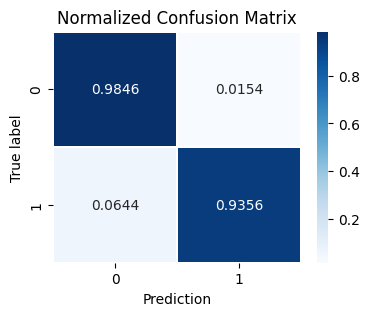


(Time taken: 11.98 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9594,0.9446,0.9569,0.9569,0.9557,0.9483,0.9581,0.9655,0.9717
ROC-AUC,0.9550,0.9410,0.9561,0.9523,0.9562,0.9447,0.9616,0.9626,0.9681


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9645 ||



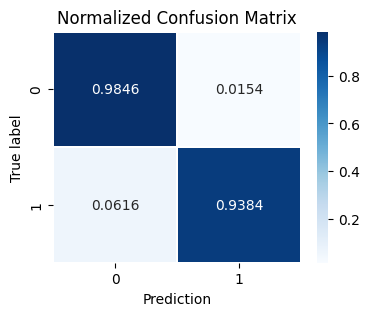


(Time taken: 12.65 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9464,0.9300,0.9443,0.9400,0.9433,0.9347,0.9467,0.9597,0.9614


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9500 ||



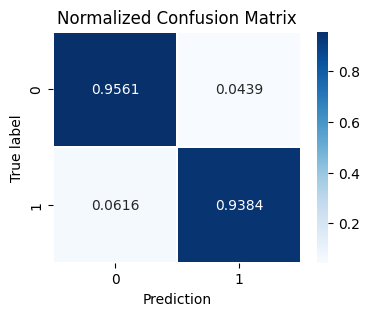


(Time taken: 8.13 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9425,0.9255,0.9438,0.9406,0.9401,0.9373,0.9433,0.9599,0.9592


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9456 ||



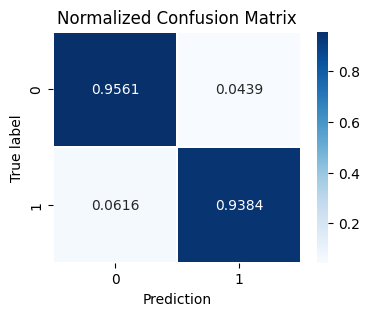


(Time taken: 4.98 secs)


In [30]:
run_experiment(model, 'histgradient')

# Multi-Layer Perceptron

In [31]:
mlpnn = MLPClassifier(
    activation='relu',
    solver='adam',
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=1000,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=SEED
)

model = make_pipeline(
    StandardScaler(),
    mlpnn
)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.8807,0.8708,0.8436,0.8658,0.8781,0.8288,0.8633,0.8719,0.8608
ROC-AUC,0.9360,0.9176,0.9115,0.9232,0.9268,0.9048,0.9282,0.9351,0.9330


Refit to full training data and evaluate:

|| Accuracy: 0.8536 || ROC-AUC: 0.9210 ||



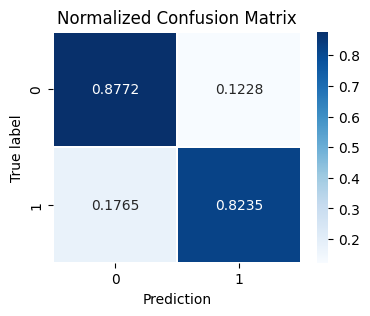


(Time taken: 34.85 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9433,0.9409,0.9433,0.936,0.9360,0.9569,0.9532
ROC-AUC,0.9529,0.9324,0.9461,0.9459,0.9489,0.946,0.9495,0.9619,0.9661


Refit to full training data and evaluate:

|| Accuracy: 0.9496 || ROC-AUC: 0.9577 ||



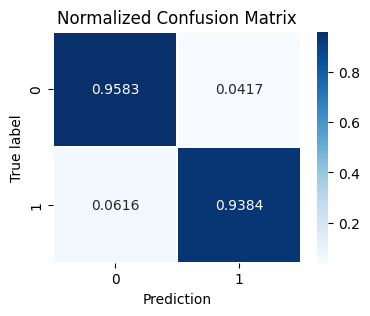


(Time taken: 9.65 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9489,0.9348,0.9407,0.9452,0.9535,0.9380,0.9457,0.9600,0.9636


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9555 ||



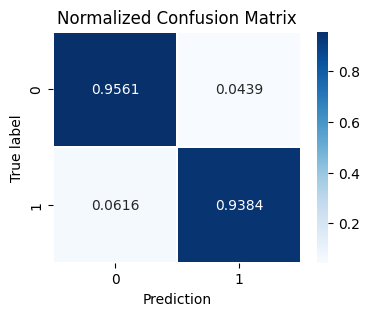


(Time taken: 8.80 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9475,0.9315,0.9449,0.9421,0.9503,0.9389,0.9472,0.9566,0.9633


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9544 ||



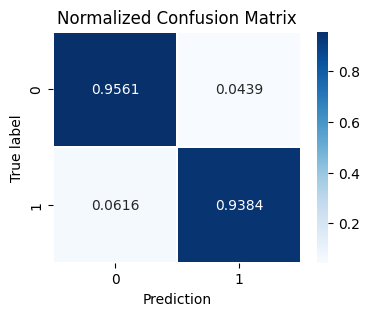


(Time taken: 8.24 secs)


In [32]:
run_experiment(model, 'mlpnn')